# Finite Difference Method for the Wave Equation on the Unit Interval

Here we solve the wave equation $\frac{\partial^2 \, u}{\partial t^2} = c^2 \frac{\partial^2 \, u}{\partial x^2}$ on the spatial domain $x \in \Omega=(0,1)$ and time domain $t \in [0,T]$ supplied with homogeneous Dirichlet boundary conditions and initial conditions for displacement and velocity. For the spatial discretization, the finite difference method on an uniform mesh is employed. For the time discretization, a fixed time step is employed.  

Reference solutions can be generated using separation of variables implementated symbolically in the function [pde_separate](https://docs.sympy.org/latest/modules/solvers/pde.html) in the sympy package.  

## Import Packages

In [2]:
using LinearAlgebra
using DifferentialEquations
using SparseArrays
using Plots
using BenchmarkTools 

Documentation of DifferentialEquations.jl  
<ul>
<li> <a href="https://diffeq.sciml.ai/dev/tutorials/ode_example/"> Examples </a>   
<li> <a href="https://diffeq.sciml.ai/stable/"> Documentation of DifferentialEquations.jl on Github </a>  
<li> <a href="https://diffeq.sciml.ai/dev/features/performance_overloads/#Function-Type-Definitions"> Specifying Jacobian types using DifferentialEquations.jl </a>   
</ul>   

## Section 1: Build and Plot Traveling Gauss-Pulse as a Reference Analytical Solution

In this part, we construct a d'Alembert reference solution using method of characteristics. This method is explained and illustrated e.g. in the slides  [http://www-thphys.physics.ox.ac.uk/people/FrancescoHautmann/Cp4p/sl_wv_3pp_12.pdf]. This solution assumes the domain in space to be unbounded. The reflection from the boundaries are *not* taken into account. An analytical reference solution is valuable to have a reference for the subsequent numerical solution.    

Notes: 
1. current version has wave in positive x direction only. The wave traveling in negative x direction is missing;  
2. the analytical solution blows up for x and/or t out of range; 

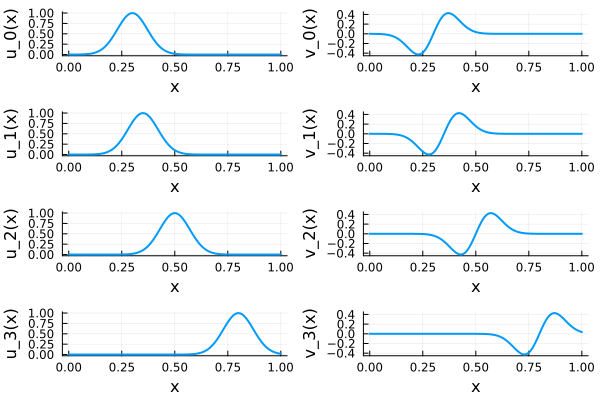

In [89]:
#..Define analytical reference solution
#..We choose as reference solution a Gauss pulse travelling to the right
#..The part of the d'Alembert solution traveling to the right is not taken into account  
#..c:  velocity of propagation 
#..x0: center of the Gauss pulse 
#..sigma: width of the Gauss pulse 
function gauss_pulse(x,t,c,x0,sigma)
    xi = x - c*t; 
    return exp(-(xi-x0)^2/sigma^2)
end

function ddt_gauss_pulse(x,t,c,x0,sigma)
    # d/dt [f(xi)] = d/dt[exp(-(xi-x0)^2)/sigma^2] = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[d xi / dt]
    # = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[-c]
    xi = x - c*t;
    return exp(-(xi-x0)^2/sigma^2)*(-2*(xi-x0)/sigma^2)*(-c)
end

#..construct the 1D mesh
nelements = 100; nnodes = nelements+1; h = 1/nelements; h2=h*h;
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..temporal mesh and set the velocity 
#..Nt and dt used for plotting only 
T = 10; Nt = 10000; dt = T/Nt; 
t = Vector(0:dt:T); 
c = .05; #.2; #..wave velocity 

#..Evaluate the initial condition  
#..hurray for broadcast in Julia 
u0 = gauss_pulse.(x,0,c,0.3,0.1)
u1 = gauss_pulse.(x,1,c,0.3,0.1)
u2 = gauss_pulse.(x,4,c,0.3,0.1)
u3 = gauss_pulse.(x,10,c,0.3,0.1)

#..Evaluate initial velocity 
v0 = ddt_gauss_pulse.(x,0,c,0.3,0.1)
v1 = ddt_gauss_pulse.(x,1,c,0.3,0.1)
v2 = ddt_gauss_pulse.(x,4,c,0.3,0.1)
v3 = ddt_gauss_pulse.(x,10,c,0.3,0.1)

#..Evaluate the analytical solution in space-time domain
#..hurray for comprehension 
Uex = [gauss_pulse(xi,tk,c,0.3,0.1) for  xi in x, tk in t]

#..plot the initial solution  
p1=plot(x,u0,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_0(x)")
p2=plot(x,v0,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_0(x)")
p3=plot(x,u1,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_1(x)")
p4=plot(x,v1,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_1(x)")
p5=plot(x,u2,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_2(x)")
p6=plot(x,v2,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_2(x)")
p7=plot(x,u3,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_3(x)")
p8=plot(x,v3,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_3(x)")

#..plot the initial solution  
p9=contour(t,x,Uex)
xlabel!("t") 
ylabel!("x")
#..plot the initial solution  
p10=surface(t,x,Uex)
xlabel!("t") 
ylabel!("x")

p11=plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = (4, 2))

In [90]:
p12=plot(p9, p10)

## Section 2: Build and Plot Standing Sine-Wave as a Reference Analytical Solution

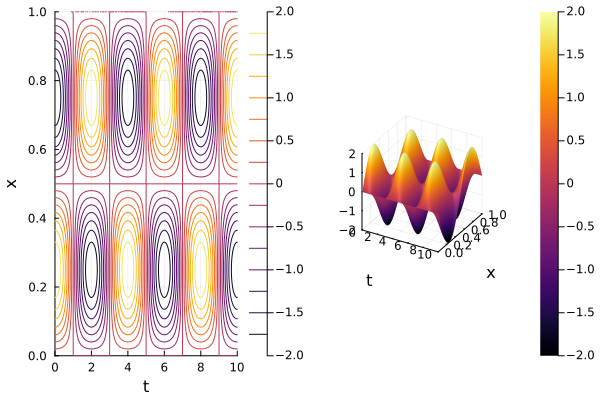

In [108]:
#..Define analytical reference solution
function sine_wave(x,t,k,omega)
    xi  = k*x - omega*t
    eta = k*x + omega*t
    return sin(xi) + sin(eta)
end

function ddt_sine_wave(x,t,k,omega)
    xi  = k*x - omega*t
    eta = k*x + omega*t
    return -omega*cos(xi) + omega*cos(eta)
end

#..construct the 1D mesh
nelements = 100; nnodes = nelements+1; h = 1/nelements; h2=h*h;
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..temporal mesh and set the velocity 
#..Nt and dt used for plotting only 
k = 2*pi; omega = pi/2  
t = Vector(0:dt:T); 

#..Evaluate the initial condition  
#..hurray for broadcast in Julia 
u0 = sine_wave.(x,0,k,omega)
u1 = sine_wave.(x,1.5,k,omega)
u2 = sine_wave.(x,4.5,k,omega)
u3 = sine_wave.(x,9.5,k,omega)

#..Evaluate initial velocity 
v0 = ddt_sine_wave.(x,0,k,omega) 
v1 = ddt_sine_wave.(x,1.5,k,omega)
v2 = ddt_sine_wave.(x,4.5,k,omega)
v3 = ddt_sine_wave.(x,9.5,k,omega)

#..Evaluate the analytical solution in space-time domain
#..hurray for comprehension 
Uex = [sine_wave(xi,tk,k,omega) for  xi in x, tk in t]

#..plot the initial solution  
p1=plot(x,u0,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_0(x)")
p2=plot(x,v0,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_0(x)")
p3=plot(x,u1,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_1(x)")
p4=plot(x,v1,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_1(x)")
p5=plot(x,u2,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_2(x)")
p6=plot(x,v2,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_2(x)")
p7=plot(x,u3,lw=2,legend=false)
xlabel!("x") 
ylabel!("u_3(x)")
p8=plot(x,v3,lw=2,legend=false)
xlabel!("x") 
ylabel!("v_3(x)")

#..plot the initial solution  
p9=contour(t,x,Uex)
xlabel!("t") 
ylabel!("x")
#..plot the initial solution  
p10=surface(t,x,Uex)
xlabel!("t") 
ylabel!("x")

p11=plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = (4, 2))
p12=plot(p9, p10)

## Section 3: Spatial Discretization: Construct the One-Dimensional Matrix

In [7]:
# struct to hold entire mesh
struct Mesh
  #..number of nodes of the mesh..   
  nnodes::Int64
  #..number of elements of the mesh..
  nelements::Int64 
  #..vector of x-coordinates of nodes of the mesh..
  Nodes::Vector{Float64}
end 

In [12]:
# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    Nodes = Vector{Float64}(0:h:1)    
    mesh = Mesh(nnodes,nelements,Nodes)     
    return mesh;
end 

# generate global stiffness matrix 
function genStiffMat(mesh::Mesh)

    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes    = nelements+1
    
    #..set mesh width and square of mesh width 
    h = 1/nelements; h2=h*h; 

    #..construct the coefficient matrix with our the boundary conditions 
    e = ones(nnodes); #..note that ones(N+1,1) does *not* work here 
    A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
    A = (1/h2)*A;     
   
    return A; 
    
end

function genVector(mesh, sourceFct::F) where F 

    #..recover mesh nodes  
    nodes = mesh.Nodes
    
    #..set vector values using broadcasting (dot syntax)  
    f = sourceFct.(nodes)
   
    return f; 
end

function genBoundaries(mesh,A)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements; h2=h*h; 
    
    #..set homogeneous Dirichlet boundary conditions at both end points  
    if (false)
        A[1,1] = 1.; A[1,2] = 0.; 
        A[end,end] = 1.; A[end,end-1] = 0.;
    elseif (false)
        #..set homogeneous Dirichlet left and homogeneous Neumann right
        display(" Setting homogeneous Neumann conditions on the right hand side:: Option-1")
        A[1,1] = 1.;        A[1,2] = 0.;         
        A[end,end] = 1/h ;  A[end,end-1] = -1/h;      
    elseif (false)
        #..set homogeneous Dirichlet left and homogeneous Neumann right
        display(" Setting homogeneous Neumann conditions on the right hand side:: Option-2")
        A[1,1] = 1.;        A[1,2] = 0.;         
        A[end,end] = 1/h ;  A[end,end-1] = -1/h;       
    elseif (true)
        display(" Setting periodic boundary conditions ")
        A = sparse(A)
        A[1,end-1] = -1/h2; 
        A[end,2]   = -1/h2;
    else 
        error(" genSolution::Error::Boundary conditions not set")
    end 
    return A  
end

genBoundaries (generic function with 1 method)

## Section 4: Implicit Integration Using Home-Brewed Code and Fixed Time Step 

Here we perform implicit time-integration using a home-brewed code and a fixed time step. Here we cheat and use the d'Alembert solution for the first two time steps. We do so an an intermediate step. 

After discretization in space we obtain: 
$\vec{u}_{tt} = c^2 \, A \, \vec{u}$ with the matrix $A$ having *negative* diagonal elements 

After discretization in space and time we obtain: 
$\vec{u}^{k-1} - 2 \, \vec{u}^k + \vec{u}^{k+1} =  (dt*c)^2 \, A \, \vec{u}^{k+1}$. Note that the right-hand side is evaluated at time-step $k+1$ to obtaion an *implicit* time integration scheme. 

We thus obtain $ [ I - (dt*c)^2 \, A] \, \vec{u}^{k+1} = 2 \, \vec{u}^k  - \vec{u}^{k-1}$ 

We can thus march in time using: 
$B \, \vec{u}^{k+1} = 2 \, \vec{u}^k  - \vec{u}^{k-1}$ where $B = I - (dt*c)^2 \, A$ 

Notes: 
1. We perform implicit time integration hoping to avoid difficulties associated with the stability of explicit time integration (size of time step related to mesh width); 
2. Even tough we perform implicit time integration, the spatial discretization has a profound effect on the accuracy of the numerical solution (likely due to a Nyquist criterium required to resolve the wave - issue left to explore);
3. Numerical results using home-brewed time-integration show the wave to propagate in two opposite directions. The analytical solution shows propagation in one direction only. Possibly we are introducing bugs in the initialization of the time-integration process;  
4. Without the use of the function genBoundaries, the case set-up corresponds to Dirichlet boundary with the boundaries eliminated. The wave bounces from the boundary and travels back into the domain;     

" Setting periodic boundary conditions "

1000

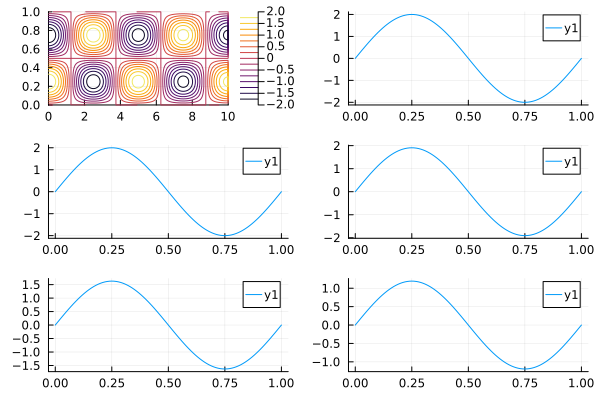

In [109]:
nelements = 100;
Nt = 1000; 

#..construct the 1D mesh
nnodes = nelements+1; h = 1/nelements; h2=h*h; 
x = Vector(0:h:1); 

#..temporal mesh and set the velocity  
T = 10; dt = T/Nt; 
t = Vector(0:dt:T); 
c = .2; #..wave velocity 

mesh = genMesh(nelements); A = -genStiffMat(mesh);

mesh = genMesh(nelements); A = genStiffMat(mesh); A = genBoundaries(mesh,A); A = -A;

#..Evaluate the analytical solution in space-time domain
#..hurray for comprehension 
Uex = [gauss_pulse(xi,tk,.01,0.3,0.1) for  xi in x, tk in t]
k = 2*pi; omega = pi/2
Uex = [sine_wave(xi,tk,k,omega) for  xi in x, tk in t]

#..perform implicit time integration 
U = zeros(nnodes,Nt+1)
display(Nt)
U[:,1] = Uex[:,1];
U[:,2] = Uex[:,2];
B = Diagonal(ones(nnodes)) - (dt*c)^2*A
for k in 3:Nt
  rhs = 2*U[:,k-1] - U[:,k-2]
  U[:,k] = B \ rhs; 
end 
p1 = contour(t,x,U)
p2 = plot(x,U[:,1])
p3 = plot(x,U[:,2])
p4 = plot(x,U[:,div(N,4)])
p5 = plot(x,U[:,div(N,2)])
p6 = plot(x,U[:,div(3*N,4)])
plot(p1,p2, p3,p4,p5,p6,layout=(3,2))

## Section 5: Explicit Time Integration using Home-Brewed Code and Fixed Time Step  

Here we perform explicit time-integration using a home-brewed code and a fixed time step. Again we cheat and use the d'Alembert solution for the first two time steps (and introduce a bug somewhere). We do so an an intermediate step. 

After discretization in space we obtain: 
$\vec{u}_{tt} = c^2 \, A \, \vec{u}$ with the matrix $A$ having *negative* diagonal elements 

After discretization in space and time we obtain: 
$\vec{u}^{k-1} - 2 \, \vec{u}^k + \vec{u}^{k+1} =  (dt*c)^2 \, A \, \vec{u}^{k}$. Note that this time the right-hand side is evaluated at time-step $k$ to obtain an *explicit* time integration scheme. 

We thus obtain $\vec{u}^{k+1} = 2 \, \vec{u}^k  - \vec{u}^{k-1} + (dt*c)^2 \, A \, \vec{u}^{k}$. 

" Setting periodic boundary conditions "

1000

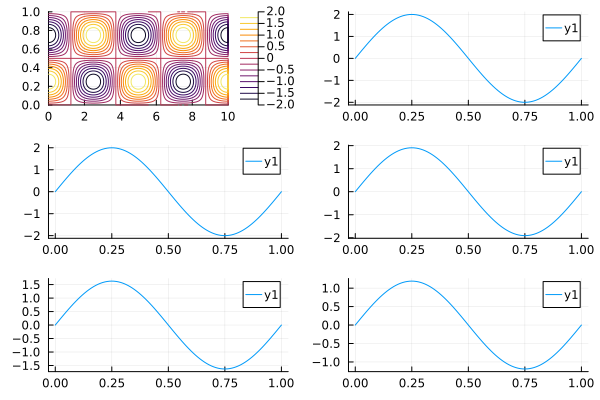

In [110]:
nelements = 100;
Nt = 1000; 

#..construct the 1D mesh
nnodes = nelements+1; h = 1/nelements; h2=h*h; 
x = Vector(0:h:1); 

#..temporal mesh and set the velocity  
T = 10; dt = T/Nt; 
t = Vector(0:dt:T); 
c = .2; #..wave velocity 

mesh = genMesh(nelements); A = -genStiffMat(mesh);

mesh = genMesh(nelements); A = genStiffMat(mesh); A = genBoundaries(mesh,A); A = -A;

#..Evaluate the analytical solution in space-time domain
#..hurray for comprehension 
Uex = [gauss_pulse(xi,tk,.01,0.3,0.1) for  xi in x, tk in t]
k = 2*pi; omega = pi/2
Uex = [sine_wave(xi,tk,k,omega) for  xi in x, tk in t]

#..perform implicit time integration 
U = zeros(nnodes,Nt+1)
display(Nt)
U[:,1] = Uex[:,1];
U[:,2] = Uex[:,2];
for k in 3:Nt
  U[:,k] = 2*U[:,k-1] - U[:,k-2] + (dt*c)^2*A*U[:,k-1]
end 
p1 = contour(t,x,U)
p2 = plot(x,U[:,1])
p3 = plot(x,U[:,2])
p4 = plot(x,U[:,div(N,4)])
p5 = plot(x,U[:,div(N,2)])
p6 = plot(x,U[:,div(3*N,4)])
plot(p1,p2, p3,p4,p5,p6,layout=(3,2))

## Section 6: (Non)-Linear Model using DifferentialEquations.jl 
Can we tweek the (non-)linear damping coefficient to obtain a periodic solution? 

In [129]:
function wave_system!(du,u,p,t)
#    A*u  
    A*u + .5*du  
end

u0 = gauss_pulse.(x,0,c,0.3,0.1)
v0 = ddt_gauss_pulse.(x,0,c,0.3,0.1)
k = 2*pi; omega = pi/2
u0 = sine_wave.(x,0,k,omega)
v0 = ddt_sine_wave.(x,0,k,omega)

tspan = (0.0,10.)               

prob = SecondOrderODEProblem(wave_system!,v0,u0,tspan)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true);

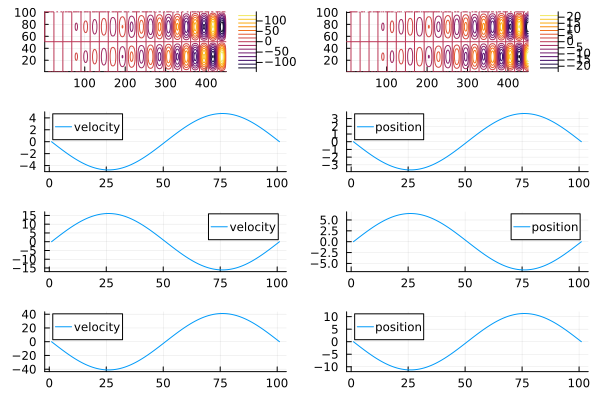

In [130]:
velind = 1:Np1; posind = Np1+1:2*Np1; 
Nt = length(sol.t)
V  = sol[velind,:]
p1 = contour(V)
U  = sol[posind,:]
p2 = contour(U)
# plot(p1, p2, layout= (1,2))
p3 = plot(sol[velind,div(Nt,4)],label="velocity")
p4 = plot(sol[posind,div(Nt,4)],label="position")
p5 = plot(sol[velind,div(Nt,2)],label="velocity")
p6 = plot(sol[posind,div(Nt,2)],label="position")
p7 = plot(sol[velind,3*div(Nt,4)],label="velocity")
p8 = plot(sol[posind,3*div(Nt,4)],label="position")
plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = (4,2)) 

## References